##### Copyright 2018 The TensorFlow Authors.

# Convolutional Variational Autoencoder

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/cvae">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cvae.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/cvae.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/cvae.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

![evolution of output during training](https://tensorflow.org/images/autoencoders/cvae.gif)

This notebook demonstrates how to generate images of handwritten digits by training a Variational Autoencoder ([1](https://arxiv.org/abs/1312.6114), [2](https://arxiv.org/abs/1401.4082)).



In [2]:
# to generate gifs
!pip install -q imageio

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## Import TensorFlow and other libraries

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

## Load the MNIST dataset
Each MNIST image is originally a vector of 784 integers, each of which is between 0-255 and represents the intensity of a pixel. We model each pixel with a Bernoulli distribution in our model, and we statically binarize the dataset.

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
#(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

In [6]:
TRAIN_BUF = 60000
BATCH_SIZE = 32

TEST_BUF = 10000

## Wire up the generative and inference network with *tf.keras.Sequential*

In our VAE example, we use two small ConvNets for the generative and inference network. Since these neural nets are small, we use `tf.keras.Sequential` to simplify our code. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Generative Network
This defines the generative model which takes a latent encoding as input, and outputs the parameters for a conditional distribution of the observation, i.e. $p(x|z)$. Additionally, we use a unit Gaussian prior $p(z)$ for the latent variable.

### Inference Network
This defines an approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for the conditional distribution of the latent representation. In this example, we simply model this distribution as a diagonal Gaussian. In this case, the inference network outputs the mean and log-variance parameters of a factorized Gaussian (log-variance instead of the variance directly is for numerical stability).

### Reparameterization Trick
During optimization, we can sample from $q(z|x)$ by first sampling from a unit Gaussian, and then multiplying by the standard deviation and adding the mean. This ensures the gradients could pass through the sample to the inference network parameters.

### Network architecture
For the inference network, we use two convolutional layers followed by a fully-connected layer. In the generative network, we mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

In [7]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim, conditional_vae=False):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.conditional_vae = conditional_vae
        self.inference_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1+10 if self.conditional_vae else 1)),
                tf.keras.layers.Conv2D(
                    filters=32,
                    kernel_size=3,
                    strides=2,
                    padding="SAME",
                    activation=tf.nn.leaky_relu),
                tf.keras.layers.Conv2D(
                    filters=64,
                    kernel_size=3,
                    strides=2,
                    padding="SAME",
                    activation=tf.nn.leaky_relu),
                #tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.generative_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(
                    input_shape=(latent_dim+10 if self.conditional_vae else latent_dim,)),
                tf.keras.layers.Dense(units=7*7*64, activation=tf.nn.relu),
                #tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
                tf.keras.layers.Conv2DTranspose(
                    filters=32,
                    kernel_size=3,
                    strides=2,
                    padding="SAME",
                    activation='relu'),
                #tf.keras.layers.BatchNormalization(),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1,
                    kernel_size=3,
                    strides=2,
                    padding="SAME"),
            ]
        )
    
    @tf.function
    def sample(self, eps=None, y=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, y=y, apply_sigmoid=True)

    def encode(self, x, y=None):
        if self.conditional_vae:
            # turn the classes numbers into one-hot vectors then reshape the vectors for further operations
            y = tf.reshape(tf.one_hot(y, 10), (y.shape[0], 1, 1, 10))
            # inputs shape will be (batch_size, 28, 28, 10+1)
            inputs = tf.concat([x, y * tf.ones([y.shape[0],28,28,10])], 3)
        else:
            inputs = x        
        mean, logvar = tf.split(self.inference_net(inputs), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        # logvar = log(sigma^2)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, y=None, apply_sigmoid=False):
        if self.conditional_vae:
            # turn the classes numbers into one-hot vectors
            y = tf.one_hot(y, 10)
            # inputs_k shape will be (batch_size, k, latent_dim+10)
            inputs = tf.concat([z, y], 1)
        else:
            inputs = z
        logits = self.generative_net(inputs)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

In [8]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=-1):
    #      normal_pdf = 1/(sigma*(2*pi)^1/2) * exp(-0.5*(x-mu)^2/sigma^2)
    # log(normal_pdf) = -log(sigma) - 0.5*log(2*pi) -0.5*(x-mu)^2/sigma^2
    #                 = -0.5 * ((x-mu)^2/sigma^2 + 2*log(sigma) + log(2*pi))
    #                 = -0.5 * ((x-mu)^2/exp(logvar) + logvar + log(2*pi)), where logvar = log(sigma^2)
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

@tf.function
def compute_loss(model, x, y=None):
    mean, logvar = model.encode(x, y=y)
    z = model.reparameterize(mean, logvar)
    x_logits = model.decode(z, y=y)

    # NOTE: The shapes of log(p(x|z)), log(p(z)) & log(g(z|x)) are (batch size, k)
    #
    # With logistic regression (i.e., binarized data), x_hat = sigmoid(logits), x = labels:
    #     cross entropy = x * -log(x_hat) + (1 - x) * -log(1 - x_hat)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logits, labels=x)
    #      p(x|z) = Bernoulli(x;DNN(z)) = Bernoulli(x;x_hat)
    #             = sum(x_hat^x * (1-x_hat)^(1-x))
    # log(p(x|z)) = sum(x*log(x_hat) + (1-x)*log(1-x_hat))
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
        
    # NOTE: the shape of log_weight is (batch size, k) 
    log_weights = logpx_z + logpz - logqz_x
    
    ### VAE
    ### loss = -E[ average( log( p(zi)*p(x|zi)/q(zi|x) ) ) ] = -E[ average( log(p(zi)) + log(p(x|zi)) - log(q(zi|x)) ) ]
    return -tf.reduce_mean(log_weights)

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        if isinstance(x, tuple):
            loss = compute_loss(model, x[0], x[1])
        else:
            loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [9]:
epochs = 200
latent_dim = 50
conditional_vae = True

## Use *tf.data* to create batches and shuffle the dataset

In [10]:
if conditional_vae:
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)
                                                      ).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)
                                                     ).shuffle(TEST_BUF).batch(BATCH_SIZE)
else:
    train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

## Training

* We start by iterating over the dataset
* During each iteration, we pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior $q(z|x)$
* We then apply the *reparameterization trick* to sample from $q(z|x)$
* Finally, we pass the reparameterized samples to the decoder to obtain the logits of the generative distribution $p(x|z)$
* **Note:** Since we use the dataset loaded by keras with 60k datapoints in the training set and 10k datapoints in the test set, our resulting ELBO on the test set is slightly higher than reported results in the literature which uses dynamic binarization of Larochelle's MNIST.

## Generate Images

* After training, it is time to generate some images
* We start by sampling a set of latent vectors from the unit Gaussian prior distribution $p(z)$
* The generator will then convert the latent sample $z$ to logits of the observation, giving a distribution $p(x|z)$
* Here we plot the probabilities of Bernoulli distributions


In [11]:
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
random_label_for_generation = tf.random.uniform(
    shape=[num_examples_to_generate],
    minval = 0,
    maxval = 10,
    dtype=np.int32)
model = CVAE(latent_dim, conditional_vae)
model.inference_net.summary()
model.generative_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        3200      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               313700    
Total params: 335,396
Trainable params: 335,396
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3136)              191296    
____________________________

In [12]:
dir_path = "{:s}vae/z-{:03d}".format("cond-" if conditional_vae else "", latent_dim)

if not os.path.exists(dir_path):
    os.makedirs(dir_path)

def generate_and_save_images(model, epoch, test_input, test_label=None, path=""):
    predictions = model.sample(test_input, y=test_label)
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
        
    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig(os.path.join(path, 'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.show()

Epoch: 200, Test set ELBO: -70.53654479980469, time elapse for current epoch 15.338083982467651


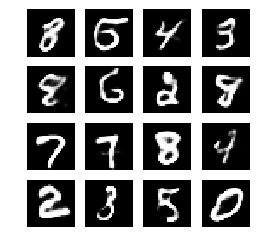

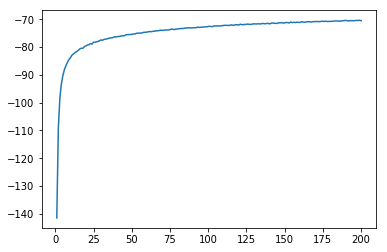

In [13]:
generate_and_save_images(model, 0, random_vector_for_generation, random_label_for_generation, dir_path)

# Set the learning phase to True
#tf.keras.backend.set_learning_phase(True)

elbo_list = []

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        compute_apply_gradients(model, train_x, optimizer)
    end_time = time.time()

    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            if isinstance(test_x, tuple):
                loss(compute_loss(model, test_x[0], test_x[1]))
            else:
                loss(compute_loss(model, test_x))
        elbo = -loss.result()
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, '
              'time elapse for current epoch {}'.format(epoch,
                                                        elbo,
                                                        end_time - start_time))
        generate_and_save_images(
            model, epoch, random_vector_for_generation, random_label_for_generation, dir_path)
        #break
        
        elbo_list.append([epoch, elbo.numpy()])
        plt.plot([e[0] for e in elbo_list], [e[1] for e in elbo_list])
        plt.show()

# save weights and elbo
model.save_weights(os.path.join(dir_path, "epcho-{:03d}.ckpt".format(len(elbo_list))))
import csv
with open(os.path.join(dir_path, "elbo-epcho-{:03d}.csv".format(len(elbo_list))), 'w') as csvfile: 
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(elbo_list)

### Display an image using the epoch number

In [14]:
def display_image(epoch_no):
    return PIL.Image.open(os.path.join(dir_path, 'image_at_epoch_{:04d}.png'.format(epoch_no)))

(-0.5, 287.5, 287.5, -0.5)

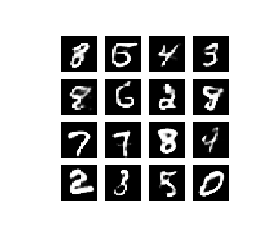

In [15]:
plt.imshow(display_image(epochs))
plt.axis('off')# Display images

### Generate a GIF of all the saved images.

In [16]:
anim_file = os.path.join(dir_path, 'cvae.gif')

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(os.path.join(dir_path, 'image*.png'))
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
    display.Image(filename=anim_file)

If you're working in Colab you can download the animation with the code below:

In [17]:
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(anim_file)